In [1]:
from resources.notebook_library import *
from resources.gate_simulation.ghz import ghz_simulation
from resources.gate_simulation.ghz import gate_simulation_functions
GateSimulation  = reload(ghz_simulation)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O ...
Constructing states and excitations ...
Constructing ground and first-excited statespace ...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian ...
Inverting NJ_hamiltonian ...


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 28.4 seconds.
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [2]:
# Global Parameters 
kSweep = [0.99]   #[0.995]

CSweep =[75]#[25,50,75]#,50,75]

SplitSweep =[10,12]#[5,10,15]#,10,15,20]# [5,10]
 

# Bounds of optimization
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.01 
DE_max = 4
tg_min = 0.8
tg_max = 1.2
rot_min = 0.8
rot_max = 1.2


# Optimization settings
opt_settings_dict = {
"ghz_dim":3,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory
'fidelity_cap': 0.97 , 'confidence_interval':0.99, #Cost function parameters
"n_cores": 16,  # Number of cores to use in optimization
"disp_bool" : False} # Show optimization progress

## Using analytical simulations

In [3]:
gamma_val = sim.parameters[sg.var('gamma')]

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)


CurrentNumberOfSimulations = 1
Results = [ [{} for j in range(len(SplitSweep))] for i in range(len(CSweep))]
for  (k, C_val , max_split) in AllParams:
    print(f'Optimizing {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    c_val = k/ (4-4*k)
    
    hardware_dict = {'c': c_val,'k':k , 'C':C_val ,'max_split': max_split}

    sim.Analytical.obtain_gate_performance_hardware(hardware_dict)
    bounds = [[0 , max_split] , [0,DE_max*np.sqrt(C_val)/gamma_val ] , [tg_min,tg_max]  ]
    # Add rotation bounds depending on the ghz_dim
    #for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_min,rot_max]) 
    for i in range(4) : bounds.append([rot_min,rot_max]) 
    sim.Analytical.optimize_gate_performance_hardware(bounds,opt_settings_dict)
    
    optimized_performance_dict = sim.Analytical.optimized_performance_dict
    opt_cost_function = gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

    tunable_params_dict = sim.Analytical.opt_tunable_dict
    
    result = {'hardware': hardware_dict , 
            'performance': optimized_performance_dict,
            'tuning': tunable_params_dict,
            'opt_settings' : opt_settings_dict, 
            'cost': opt_cost_function}
    i = np.where(C_val == np.array(CSweep) )[0][0]
    j = np.where(max_split == np.array(SplitSweep) )[0][0]
    Results[i][j] = result

    clear_output(wait=True)

Optimizing 2 out of 2


# Plot result

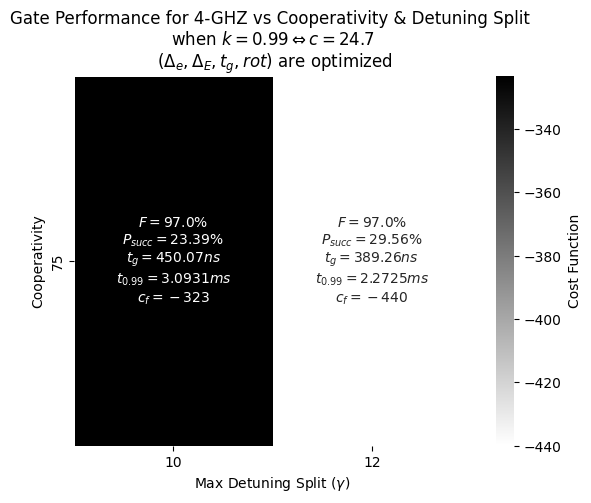

In [9]:
plot_results(Results)

# Print results

In [4]:
for i,C in enumerate(CSweep):
    for j,spl in enumerate(SplitSweep):
        pass
        #print(Results[i][j]['tuning'][sg.var('DE')]/np.sqrt(C))
        #print(Results[i][j]['tuning'][sg.var('De')],spl)
        #print([Results[i][j]['tuning'][sg.var(f'r{k}_r')]  for k in range(opt_settings_dict["ghz_dim"] ) ])
       

In [5]:
costs = np.array([[Results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(CSweep))])
i_min, j_min = ArgMin(costs)

Results[i_min][j_min]

{'hardware': {'c': 24.74999999999998, 'k': 0.99, 'C': 75, 'max_split': 12},
 'performance': {'gate_time': 7.2490051847014065,
  'p_success': 0.07360694006027274,
  'fidelity': 0.9700030254020928,
  't_conf': 0.005096905213220893},
 'tuning': {De: 0.9676165767775737,
  DE: 2.5662939458772964,
  tgr: 0.9063367002159448,
  r0_r: 1.049882450823706,
  r1_r: 1.06687516781161,
  r2_r: 1.0239092564634629,
  r3_r: 1.1117619307627118,
  tgs: 7.2490051847014065,
  pss: 0.07360694006027274},
 'opt_settings': {'ghz_dim': 3,
  'swap_into_memory': False,
  'fidelity_cap': 0.97,
  'confidence_interval': 0.99,
  'n_cores': 16,
  'disp_bool': False},
 'cost': -196.19748811614036}

# Tests

In [10]:
def plot_results(result_array):
    '''
    Plots heatmap for result array.
    '''    
    shape = np.shape(result_array)
    C_dim = shape[0]
    spl_dim = shape[1]
    Analytical = True
    
    kPlot = result_array[0][0]['hardware']['k']
    cPlot = kPlot / (4-4*kPlot)

    
    opt_settings_dict = result_array[0][0]['opt_settings']
    
    C_sweep = []
    AllLabels = [["" for i in range(spl_dim)]for j in range(C_dim)]
    plotted_values = np.zeros(np.array(AllLabels).shape)
    for i in range(C_dim):
        C = result_array[i][0]['hardware']['C']
        C_sweep.append(C)
        
        spl_sweep = []
        for j in range(spl_dim):
            spl = result_array[0][j]['hardware']['max_split'] 
            spl_sweep.append(spl)
            
            res = result_array[i][j]
            
            # Extreact parameters
            opt_tg = res['performance']['gate_time']
            opt_fid = res['performance']['fidelity']
            opt_p_success = res['performance']['p_success']
            fidelity , p_success, gate_time = opt_fid , opt_p_success , opt_tg
            t_conf = res['performance']['t_conf']
            min_cost_function = res['cost']      
            confidence_interval = opt_settings_dict["confidence_interval"]
            
            plotted_values[i][j] = min_cost_function       
            

            AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
            AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
            AllLabels[i][j] += '$t_g='+ str(quantiphy.Quantity(gate_time/experimental_values_dict['gamma']))+r's$'
            AllLabels[i][j] += '\n$t_{'+str(np.round(confidence_interval,decimals=2)) +'} = '+ str(quantiphy.Quantity(t_conf)) +r's$'
            AllLabels[i][j] += '\n$c_f='+ str( int( min_cost_function))+'$'
            


    fig, ax = plt.subplots()


    ax = sns.heatmap(plotted_values,yticklabels=C_sweep,xticklabels=spl_sweep,cmap='gray_r', linewidth=0.5,annot=AllLabels, fmt = ''\
        ,cbar_kws={'label': 'Cost Function'}) #Greys
    ax.set_ylabel('Cooperativity')
    ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
    ax.set_title(f'Gate Performance for {opt_settings_dict["ghz_dim"]}-GHZ vs Cooperativity & Detuning Split \nwhen $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'
    +r' $(\Delta_e,\Delta_E,t_g,rot)$ are optimized')
    plt.show() 

<>:42: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \%
<>:57: DeprecationWarning: invalid escape sequence \L
<>:42: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \%
<>:57: DeprecationWarning: invalid escape sequence \L
<ipython-input-10-da695dab3d27>:42: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
<ipython-input-10-da695dab3d27>:43: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
<ipython-input-10-da695dab3d27>:57: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance for {opt_settings_dict["ghz_dim"]}-GHZ vs Cooperativity & Detuning Split \nwhen $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'


In [18]:
res =Results[1][1]
opt_settings_dict = {
"ghz_dim":3,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory
'fidelity_cap': 0.97 , 'confidence_interval':0.99, #Cost function parameters
"n_cores": 16,  # Number of cores to use in optimization
"disp_bool" : False} # Show optimization progress
gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

-604.3083645007239

In [20]:
res["tuning"]

{De: 5.99604288253885,
 DE: 8.582101871850197,
 tgr: 0.8569511475082925,
 r0_r: 1.1744624409479043,
 r1_r: 1.1289289271257927,
 r2_r: 1.1860735327063425,
 r3_r: 1.1114165105917566,
 tgs: 12.672265746115981,
 pss: 0.3557343017769333}

In [21]:
sim.Analytical.tunable_performance( res["tuning"],opt_settings_dict)


{'gate_time': 12.672265746115981,
 'p_success': 0.3557343017769333,
 'fidelity': 0.8724321497105694}

In [11]:
t = np.pi/(a+c-2*b)

rot = (a-b)*t

el = [a,b,b,c]

for i,e in enumerate(el): evolution[i,i] = np.e**(e*t*1j)

In [14]:
GHZ_3_symbolic_fidelity_from_evolution(evolution,rot).subs(r1_r=1,r2_r=1,r0_r=1)

0.9999999999999993

In [19]:
def ten_r(rot_matr,qubit,n_qubits):
    '''
    Works out the tensor product of U in a n_qubit level system if U is diagonal.
    '''
    ten_matr = sg.Matrix(sg.SR,np.zeros((1,1)))
    ten_matr[0,0] = 1
    
    I = sg.identity_matrix(2)
    for i in range(n_qubits):
        if i ==qubit:
            ten_matr = ten_matr.tensor_product(rot_matr)
        else:
            ten_matr = ten_matr.tensor_product(I)
    return ten_matr


In [20]:
rotation = sg.var('a')
rots = []
for i in range(4): rots.append(sg.var(f'r{i}_r')*rotation)   

R = []
for rot_val in rots:
    r_matr = sg.Matrix(sg.SR,np.zeros((2,2)))
    r_matr[0,0] = 1
    r_matr[1,1] = sg.exp(sg.I*rot_val)
    R.append(r_matr)

In [72]:
evol = ten_r(R[0],1,2)
print(evol)

[           1          0.0|           0            0]
[         0.0 e^(I*a*r0_r)|           0            0]
[-------------------------+-------------------------]
[           0            0|           1          0.0]
[           0            0|         0.0 e^(I*a*r0_r)]


In [75]:
def ten_u(pair,evolution,n_qubits):
    '''
    Works out the tensor product of U in a 4 qubit level system if U is diagonal.
    '''
    ten_matr = sg.Matrix(sg.SR,np.zeros((2**n_qubits,2**n_qubits)))

    for i in range(2**n_qubits):
        i_bin = "{0:b}".format(i)
        # Add zeros
        i_bin = ('0'*(n_qubits-len(i_bin)) + i_bin)

        u_bin = i_bin[pair[0]] + i_bin[pair[1]]
        u_el = int(u_bin,2)
        print(i,u_el)
        ten_matr[i,i] = evolution[u_el,u_el]
    return ten_matr
ten_u((0,1),evol,3)

0 0
1 0
2 1
3 1
4 2
5 2
6 3
7 3


[           1          0.0          0.0          0.0          0.0          0.0          0.0          0.0]
[         0.0            1          0.0          0.0          0.0          0.0          0.0          0.0]
[         0.0          0.0 e^(I*a*r0_r)          0.0          0.0          0.0          0.0          0.0]
[         0.0          0.0          0.0 e^(I*a*r0_r)          0.0          0.0          0.0          0.0]
[         0.0          0.0          0.0          0.0            1          0.0          0.0          0.0]
[         0.0          0.0          0.0          0.0          0.0            1          0.0          0.0]
[         0.0          0.0          0.0          0.0          0.0          0.0 e^(I*a*r0_r)          0.0]
[         0.0          0.0          0.0          0.0          0.0          0.0          0.0 e^(I*a*r0_r)]

In [77]:
def ten_u(pair,evolution,n_qubits):
    '''
    Works out the tensor product of U in a 4 qubit level system if U is diagonal.
    '''
    ten_matr = sg.Matrix(sg.SR,np.zeros((2**n_qubits,2**n_qubits)))

    for i in range(2**n_qubits):
        i_bin = "{0:b}".format(i)
        # Add zeros
        i_bin = ('0'*(n_qubits-len(i_bin)) + i_bin)
        i_bin = i_bin[::-1]
        u_bin = i_bin[pair[0]] + i_bin[pair[1]]
        u_el = int(u_bin,2)
        print(i,u_el)
        ten_matr[i,i] = evolution[u_el,u_el]
    return ten_matr
ten_u((0,1),evol,3)

0 0
1 2
2 1
3 3
4 0
5 2
6 1
7 3


[           1          0.0          0.0          0.0          0.0          0.0          0.0          0.0]
[         0.0            1          0.0          0.0          0.0          0.0          0.0          0.0]
[         0.0          0.0 e^(I*a*r0_r)          0.0          0.0          0.0          0.0          0.0]
[         0.0          0.0          0.0 e^(I*a*r0_r)          0.0          0.0          0.0          0.0]
[         0.0          0.0          0.0          0.0            1          0.0          0.0          0.0]
[         0.0          0.0          0.0          0.0          0.0            1          0.0          0.0]
[         0.0          0.0          0.0          0.0          0.0          0.0 e^(I*a*r0_r)          0.0]
[         0.0          0.0          0.0          0.0          0.0          0.0          0.0 e^(I*a*r0_r)]